# Introduction to OpenGym using the CartPole problem

OpenGym is n interesting testbed for RL algorithms. 

https://gym.openai.com/envs/#classic_control

Today we will work in the CartPole environment.

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import pandas as pd

import gym
env = gym.make('CartPole-v1')
env.reset()

[2018-04-12 16:32:10,710] Making new env: CartPole-v1


array([-0.01098807,  0.02757705,  0.00873714, -0.03953171])

## Description of the environment

Poor documentation. Usually you have to go to code. However details are not necessary to run RL algorithms, just to interprete them.

In the case of the CartPole, go to:

https://gym.openai.com/envs/CartPole-v1/

However, there are some methods implemented that show the minimum necessary information

In [3]:
# Two discrete actions in the environment (push towards each direction)
print(env.action_space)

Discrete(2)


Means 2 discrete possible actions. In this case:

<table>
<thead>
<tr>
<th>Num</th>
<th>Action</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>Push cart to the left</td>
</tr>
<tr>
<td>1</td>
<td>Push cart to the right</td>

In [4]:
# Four dimensional space.
print(env.observation_space)

Box(4,)


That means *4 variables "Continuous with Bounds"* (box). 

There also exist **Discrete** observations.

They can be organized as:

- **Dictionary**, fi. Dict({"position": Discrete(5), "velocity": Box(low=np.array([0,0]),high=np.array([1,5]))}),
- **Tuples** , fi. Tuple([Discrete(5), Box(low=np.array([0,0]),high=np.array([1,5]))]),
- **Multidiscrete**, fi. MultiDiscrete([ 2, 2, 100]),

In [5]:
# Show the limits of each variable

print(env.observation_space.high)
print(env.observation_space.low)

[  4.80000000e+00   3.40282347e+38   4.18879020e-01   3.40282347e+38]
[ -4.80000000e+00  -3.40282347e+38  -4.18879020e-01  -3.40282347e+38]


<table>
<thead>
<tr>
<th>Num</th>
<th>Observation</th>
<th>Min</th>
<th>Max</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>Cart Position</td>
<td>-4.8</td>
<td>4.8</td>
</tr>
<tr>
<td>1</td>
<td>Cart Velocity</td>
<td>-&infin;</td>
<td>&infin;</td>
</tr>
<tr>
<td>2</td>
<td>Pole Angle rads</td>
<td>-0.42</td>
<td>0.42</td>
</tr>
<tr>
<td>3</td>
<td>Pole Velocity At Tip</td>
<td>-&infin;</td>
<td>&infin;</td>

## Acting in the environment

The environment’s step function returns exactly what we need. In fact, step returns four values. These are:

- **observation** (*object*): an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game.
    
- **reward** (*float*): amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.
    
- **done** (*boolean*): whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)
    
- **info** (*dict*): diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment’s last state change). However, official evaluations of your agent are not allowed to use this for learning.


In [6]:
obs1 = env.reset()  # Starting state
action = env.action_space.sample() # take a random action
obs2, reward, done, info = env.step(action)  # take the action and observe results
print('s =',obs1)  
print('a =',action)
print('r =',reward)
print("s'=",obs2)
print(done)

s = [-0.02616967 -0.03642189 -0.006428    0.03753895]
a = 0
r = 1.0
s'= [-0.02689811 -0.23145107 -0.00567722  0.32818687]
False


That's all the information we need in model-free RL algorithms!

Let's execute now a sequence of random actions. Render will show us a visualization of the environment

In [7]:
# Generate one random trial
done= False  
while not done:
    env.render()
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action

In [8]:
# Let's compute the average return for 10 random trials and the number of timesteps
t=0
tsteps=0
treward=0
for nexps in range(10):   # Let's do 10 trials
    done= False  
    env.reset() 
    while not done:
        env.render()
        observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
        treward = treward + reward
        tsteps = tsteps + 1

print('Average reward',treward/10)
print('Average time steps before ending episode',tsteps/10)


Average reward 15.2
Average time steps before ending episode 15.2


Trying to apply Q-learning, we have to define the table that will store the Q-value function. But we have a problem here, because our **states are defined by continuous variables**.

One solution could be to discretize values by bining them.

## Discretization of the state

First we have to declare how many "discrete" states I will allow per variable, and later define the discretization procedure 

In [9]:
discr_vector = (1,3,10,20,)   # Resolution degrees: How many discrete states per variable. Play with this parameter!

class Discretizer ():
    """ mins: vector with minimim values allowed for each variable
        maxs: vector with maximum values allowed for each variable
    """
    def __init__(self, vector_discr, mins, maxs):
        self.mins=mins
        self.maxs=maxs
        
    def Discretize(self, obs):
        ratios = [(obs[i] + abs(self.mins[i])) / (self.maxs[i] - self.mins[i]) for i in range(len(obs))]
        new_obs = [int(round((discr_vector[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(discr_vector[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return tuple(new_obs)

# Create the discretizer with maxs and mins from the enviroment
d = Discretizer(discr_vector, env.observation_space.low, env.observation_space.high)

# It will not work because limits for two varaibles are almost infinite (in other case could work)

In [10]:
# Another approach. Try a lot of random actions and find maximum and minimum for each variable empirically
# This approach also has some problems, because some states are found with very low probability.

lO=np.zeros((10000,4))
for nexp in range(10000):   # Let's do 10 trials
    done= False  
    env.reset() 
    while not done:
        observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
        treward = treward + reward
        tsteps = tsteps + 1
        lO[nexp]=np.array(observation)
        
maxv=[np.max(lO[:,i]) for i in range(lO.shape[1])]
minv=[np.min(lO[:,i]) for i in range(lO.shape[1])]

# Now we have a better discretization based on common values
d = Discretizer(discr_vector, minv, maxv)

# or even better
minv = [env.observation_space.low[0], minv[1], env.observation_space.low[2], minv[3]]
maxv = [env.observation_space.high[0], maxv[1], env.observation_space.high[2], maxv[3]]
d = Discretizer(discr_vector, minv, maxv)

## Q-learning implementation

#### Define epsilon-greedy procedure

In [11]:
def choose_action(state, epsilon):
    return env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(Q[state])


#### Implementation of Q-learning

In [12]:
# Set parameters for learning
alpha = 0.2
epsilon = 0.1
gamma = 1

# Create and initialize Q-value table to 0
Q = np.zeros(discr_vector + (env.action_space.n,))

# Just to store the long-term-reward of the last 100 experiments 
scores = deque(maxlen=100)
lrews = []
lr = []

for episode in range(1,10001):
    done = False
    R, reward = 0,0
    state = d.Discretize(env.reset())
    while done != True:
            action = choose_action(state, epsilon) 
            obs, reward, done, info = env.step(action) 
            new_state = d.Discretize(obs)
            Q[state][action] += alpha * (reward + gamma * np.max(Q[new_state]) - Q[state][action]) #3
            R = gamma * R + reward
            state = new_state   
    lr.append(R)
    scores.append(R)
    mean_score = np.mean(scores)
    lrews.append(np.mean(scores))
    if mean_score >= 250 and episode >= 100:
        print('Ran {} episodes. Solved after {} trials ✔'.format(episode, episode - 100))    
        break
    if episode % 100 == 0:
        print('Episode {} Total Reward: {} Average Reward: {}'.format(episode,R,np.mean(scores)))


Episode 100 Total Reward: 127.0 Average Reward: 18.98
Episode 200 Total Reward: 70.0 Average Reward: 57.23
Ran 264 episodes. Solved after 164 trials ✔


This is how long term reward increses with episodes. Remember that long-term-reward represents the number of time steps before failure. We decided the task was learnt when the average long-term-reward of the last 100 experiences is higher than 200. 

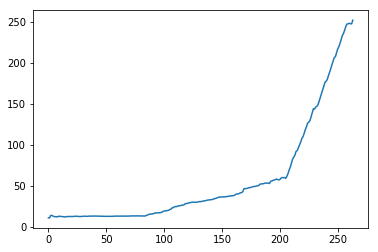

In [13]:
plt.plot(lrews)
plt.show()


Notice that, being results shown are average of last 100 experiments, there is a "delay" of 100 episodes in detecting that desired behavior has been learnt. We could plot the actual reward for each episode, but is too varaible to see anything. It is better to average returns.

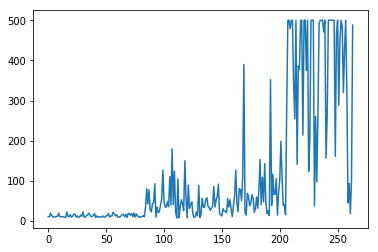

In [14]:
plt.plot(lr)
plt.show()

Why so many peaks? Remeber! We take random actions with probability $\epsilon$. Notice difference in performance when we set epsilon to zero. That's because we use an off-policy method.

In [15]:
def rollout(epsilon, render=True):
    done = False
    R, reward = 0,0
    state = d.Discretize(env.reset())
    while done != True:
            if render: 
                env.render()
            action = choose_action(state, epsilon) 
            obs, reward, done, info = env.step(action) 
            R = gamma * R + reward
            state = d.Discretize(obs)
    return R

rollout(epsilon)
rollout(0)

print('Average reward for epsilon',epsilon,':', np.mean([rollout(epsilon, render=False) for _ in range(20)]))
print('Average reward for epsilon 0:', np.mean([rollout(0,render=False) for _ in range(20)]))

Average reward for epsilon 0.1 : 434.5
Average reward for epsilon 0: 498.15


But instead of stopping after return in last 100 experiments is higher than 200, let's iterate a fixed number of experiences

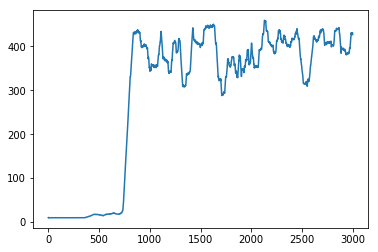

In [16]:
# Set parameters for learning
alpha = 0.2
epsilon = 0.1
gamma = 1

# Create and initialize Q-value table to 0
Q = np.zeros(discr_vector + (env.action_space.n,))

# Just to store the long-term-reward of the last 100 experiments 
scores = deque(maxlen=100)
lrews = []

for episode in range(1,3001):
    done = False
    R, reward = 0,0
    state = d.Discretize(env.reset())
    while done != True:
            action = choose_action(state, epsilon) 
            obs, reward, done, info = env.step(action) 
            new_state = d.Discretize(obs)
            Q[state][action] += alpha * (reward + gamma * np.max(Q[new_state]) - Q[state][action]) #3
            R = gamma * R + reward
            state = new_state   
    scores.append(R)
    mean_score = np.mean(scores)
    lrews.append(np.mean(scores))

plt.plot(lrews)
plt.show()

Inestability can be produced wrong discretization and large alpha values and epsilon values. When discretization is normally good but no for some "frontier" states, exploration find them and large alpha in Q-values which changes policy a lot.


Not bad. However, in RL results depend a lot on randomization, so it's a good thing repeat several times the same procedure

In [17]:
l100rew=[]
for _ in range(10):
    print('*** New experiment!')
    # Create and initialize Q-value table to 0
    Q = np.zeros(discr_vector + (env.action_space.n,))

    # Just to store the long-term-reward of the last 100 experiments 
    scores = deque(maxlen=100)
    lrews = []

    for episode in range(1,3001):
        done = False
        R, reward = 0,0
        state = d.Discretize(env.reset())
        while done != True:
                action = choose_action(state, epsilon) 
                obs, reward, done, info = env.step(action) 
                new_state = d.Discretize(obs)
                Q[state][action] += alpha * (reward + gamma * np.max(Q[new_state]) - Q[state][action]) #3
                R = gamma * R + reward
                state = new_state   
        scores.append(R)
        mean_score = np.mean(scores)
        lrews.append(np.mean(scores))
        #if mean_score >= 195 and episode >= 100:
        #    print('Ran {} episodes. Solved after {} trials ✔'.format(episode, episode - 100))    
        #    break
        #if episode % 100 == 0:
        #    print('Episode {} Total Reward: {} Average Reward: {}'.format(episode,G,np.mean(scores)))
    l100rew.append(lrews)
    
    

*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!


C:\Users\Inanna\Anaconda2\envs\tensorflow\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


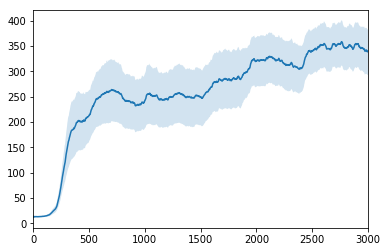

In [18]:
sns.tsplot(data=l100rew) #, err_style="unit_traces")
plt.show()

Not very smooth and somewhat slow in learning. We could do better setting a variable alpha and epsilon (why?)

$$ \epsilon = \max \left( \epsilon_{min}, 1- \log \frac{t+1}{tau} \right) $$
$$ \alpha = \max \left( \alpha_{min}, 1- \log \frac{t+1}{tau} \right) $$

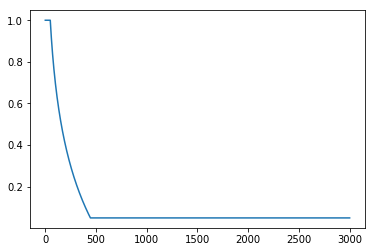

In [19]:
min_alpha=0.05
min_epsilon = 0.01
tau = 50

def set_epsilon(t, tau):
    return max(min_epsilon, min(1, 1.0 - math.log10((t + 1) / tau)))

def set_alpha(t, tau):
    return max(min_alpha, min(1.0, 1.0 - math.log10((t + 1) / tau)))

plt.plot([set_alpha(i, tau) for i in range(3001)])
plt.show()

*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!


C:\Users\Inanna\Anaconda2\envs\tensorflow\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


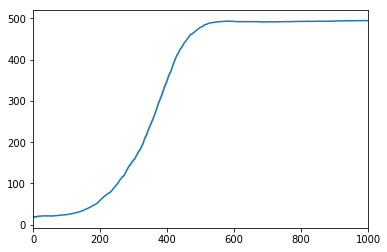

In [20]:
l100rew=[]
for _ in range(10):
    print('*** New experiment!')
    # Create and initialize Q-value table to 0
    Q = np.zeros(discr_vector + (env.action_space.n,))

    # Just to store the long-term-reward of the last 100 experiments 
    scores = deque(maxlen=100)
    lrews = []

    for episode in range(1,1001):
        done = False
        e = set_epsilon(episode, tau)
        a = set_alpha(episode, tau)
        R, reward = 0,0
        state = d.Discretize(env.reset())
        while done != True:
                action = choose_action(state, e) 
                obs, reward, done, info = env.step(action) 
                new_state = d.Discretize(obs)
                Q[state][action] += a * (reward + gamma * np.max(Q[new_state]) - Q[state][action]) #3
                R = gamma * R + reward
                state = new_state   
        scores.append(R)
        mean_score = np.mean(scores)
        lrews.append(np.mean(scores))
    l100rew.append(lrews)

sns.tsplot(data=l100rew) #, err_style="unit_traces")
plt.show()

## Exercises

1. Play with parameters for discretization and see how they affect performance and convergence
2. Try other methods to decrese $\alpha$ and $\epsilon$
3. Try Boltzman exploration instead of $\epsilon$ greedy
4. Obtain Q-values for starting state. Is that strange? Can you explain/solve the problem using gamma different to 1? Try with gamma 0.99 for example.
5. **Implement Monte-Carlo for this problem and compare performance and variance with Q-learning**
6. **Implement n-steps Q-learning for this problem and compare performance with Q-learning**
7. **Implement Sarsa on this problem**
8. **Adapt everything has been done here to another Gym problem, f.i. Acrobot-v1 or MountainCar-v0**

In [4]:
env.close()